In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import F1Score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [3]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10          
EPOCHS = 20              
BATCH_SIZE = 64 

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

In [6]:
print(f"X_train shape after preprocessing: {X_train.shape}")
print(f"y_train shape after preprocessing: {y_train.shape}")
print(f"X_test shape after preprocessing: {X_test.shape}")
print(f"y_test shape after preprocessing: {y_test.shape}")
print(f"Input shape to be used: {INPUT_SHAPE}, Number of classes: {NUM_CLASSES}\n")

X_train shape after preprocessing: (50000, 32, 32, 3)
y_train shape after preprocessing: (50000, 10)
X_test shape after preprocessing: (10000, 32, 32, 3)
y_test shape after preprocessing: (10000, 10)
Input shape to be used: (32, 32, 3), Number of classes: 10



In [11]:
class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

def plot_history(history_object, title):
    """Function to plot training & validation loss and F1-score/accuracy."""
    history_data = history_object.history

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_data['loss'], label='Training Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.title(f'Loss: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    f1_key = None
    for key in history_data.keys():
        if 'f1' in key.lower() and 'val' not in key.lower():
            f1_key = key
            break
    val_f1_key = None
    for key in history_data.keys():
        if 'f1' in key.lower() and 'val' in key.lower():
            val_f1_key = key
            break
    
    if f1_key and val_f1_key:
        plt.subplot(1, 2, 2)
        plt.plot(history_data[f1_key], label=f'Training Macro F1-Score ({f1_key})')
        plt.plot(history_data[val_f1_key], label=f'Validation Macro F1-Score ({val_f1_key})')
        plt.title(f'Macro F1-Score: {title}')
        plt.xlabel('Epoch')
        plt.ylabel('F1-Score')
        plt.legend()
    elif 'accuracy' in history_data and 'val_accuracy' in history_data:
        plt.subplot(1, 2, 2)
        plt.plot(history_data['accuracy'], label='Training Accuracy')
        plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy: {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        print(f"Could not find F1-score or accuracy metrics in history for {title}.")

    plt.tight_layout()
    plt.show()

def evaluate_model_f1(model, X_test_data, y_test_data_one_hot, model_name="Model"):
    """Evaluates the model and calculates macro F1-score."""
    print(f"\nEvaluating {model_name}...")
    loss, accuracy, f1_metric_value = model.evaluate(X_test_data, y_test_data_one_hot, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Macro F1-Score (from model.evaluate): {f1_metric_value:.4f}")

    y_pred_proba = model.predict(X_test_data)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true_classes = np.argmax(y_test_data_one_hot, axis=1)
    
    sklearn_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    print(f"Test Macro F1-Score (calculated with scikit-learn): {sklearn_f1:.4f}")
    return sklearn_f1

f1_metric_compiler = F1Score(average='macro', name='f1_score_macro')
METRICS_TO_COMPILE = ['accuracy', f1_metric_compiler]

experiment_results = {}

In [10]:
def create_model_varied_conv_layers(num_conv_layers, input_shape, num_classes):
    model = models.Sequential(name=f"CNN_{num_conv_layers}_ConvLayers")
    model.add(layers.Input(shape=input_shape))

    filters = 32
    kernel_size = (3, 3)
    pool_size = (2, 2)
    
    current_height = input_shape[0]
    current_width = input_shape[1]

    for i in range(num_conv_layers):
        current_filters = filters * (2**(i // 2)) 
        model.add(layers.Conv2D(current_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        
        if current_height >= pool_size[0] and current_width >= pool_size[1]:
            model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))
            current_height //= pool_size[0]
            current_width //= pool_size[1]
        else:
            print(f"Skipping MaxPooling2D for conv_layer_{i+1} due to small dimensions: {current_height}x{current_width}")
        
    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1")) 
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

num_layers_variations = [2, 4, 6] 
histories_conv_layers = {}
f1_scores_conv_layers = {}

print("--- Starting Experiment: Number of Convolutional Layers ---")
for num_layers in num_layers_variations:
    model_name = f"{num_layers}_conv_layers"
    print(f"\nTraining model with {num_layers} convolutional layer(s)...")
    model = create_model_varied_conv_layers(num_layers, INPUT_SHAPE, NUM_CLASSES)
    model.summary() 
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1) 
    
    histories_conv_layers[model_name] = history.history
    
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_conv_layers[model_name] = f1

experiment_results['num_conv_layers'] = {
    'f1_scores': f1_scores_conv_layers,
    'histories': histories_conv_layers 
}

--- Starting Experiment: Number of Convolutional Layers ---

Training model with 2 convolutional layer(s)...


Model: "CNN_2_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,706 (1.04 MB)

 Trainable params: 273,706 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.2985 - f1_score_macro: 0.4589 - loss: 1.9083 - val_accuracy: 0.5177 - val_f1_score_macro: 0.5196 - val_loss: 1.3620
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4845 - f1_score_macro: 0.4782 - loss: 1.4322 - val_accuracy: 0.5674 - val_f1_score_macro: 0.5705 - val_loss: 1.2252
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5378 - f1_score_macro: 0.5344 - loss: 1.2874 - val_accuracy: 0.5965 - val_f1_score_macro: 0.5887 - val_loss: 1.1376
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5664 - f1_score_macro: 0.5636 - loss: 1.2158 - val_accuracy: 0.6362 - val_f1_score_macro: 0.6350 - val_loss: 1.0411
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5921 - f1_score_macro: 0.5899 - loss: 1.1421 - val_accuracy: 0.6516 - val_f1_score_macro: 0.6476 - val_loss: 0.9901
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6161 - f1_score_macro:

Model: "CNN_4_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_4 (Conv2D)         │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,754 (389.66 KB)

 Trainable params: 99,754 (389.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.2787 - f1_score_macro: 0.4411 - loss: 1.9191 - val_accuracy: 0.5148 - val_f1_score_macro: 0.5143 - val_loss: 1.3339
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5076 - f1_score_macro: 0.5011 - loss: 1.3568 - val_accuracy: 0.5857 - val_f1_score_macro: 0.5780 - val_loss: 1.1609
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5909 - f1_score_macro: 0.5874 - loss: 1.1443 - val_accuracy: 0.6371 - val_f1_score_macro: 0.6222 - val_loss: 1.0108
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6499 - f1_score_macro: 0.6473 - loss: 1.0046 - val_accuracy: 0.6566 - val_f1_score_macro: 0.6583 - val_loss: 0.9582
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6785 - f1_score_macro: 0.6763 - loss: 0.9174 - val_accuracy: 0.6827 - val_f1_score_macro: 0.6872 - val_loss: 0.8783
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7058 - f1_score_macro:

Model: "CNN_6_ConvLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_4 (Conv2D)         │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_5 (Conv2D)         │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_6 (Conv2D)         │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,810 (1.16 MB)

 Trainable params: 304,810 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-05-30 13:42:51.955352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1368', 116 bytes spill stores, 116 bytes spill loads

2025-05-30 13:42:52.423388: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1368', 148 bytes spill stores, 148 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.2265 - f1_score_macro: 0.4182 - loss: 2.0186 - val_accuracy: 0.4761 - val_f1_score_macro: 0.4643 - val_loss: 1.3939
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4885 - f1_score_macro: 0.4788 - loss: 1.4074 - val_accuracy: 0.5621 - val_f1_score_macro: 0.5594 - val_loss: 1.1762
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5754 - f1_score_macro: 0.5703 - loss: 1.1817 - val_accuracy: 0.6116 - val_f1_score_macro: 0.5955 - val_loss: 1.0888
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6329 - f1_score_macro: 0.6272 - loss: 1.0372 - val_accuracy: 0.6469 - val_f1_score_macro: 0.6405 - val_loss: 0.9810
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6735 - f1_score_macro: 0.6723 - loss: 0.9298 - val_accuracy: 0.6671 - val_f1_score_macro: 0.6699 - val_loss: 0.9348
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7063 - f1_score_macro: 0.7061 

In [14]:
print("\n--- F1-Scores (Number of Filters) ---")
for name, score in f1_scores_conv_layers.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Number of Filters) ---
2_conv_layers: 0.7130
4_conv_layers: 0.7363
6_conv_layers: 0.7239



--- Loss Graphs (Number of Convolutional Layers) ---


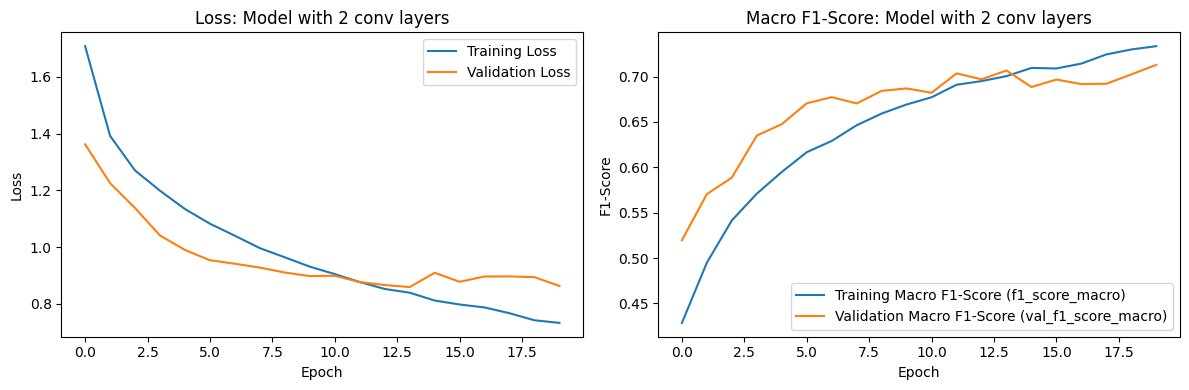

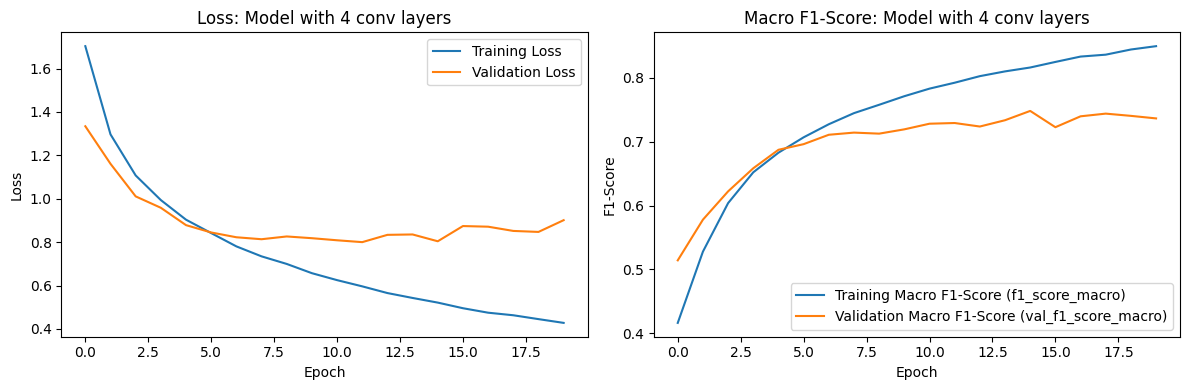

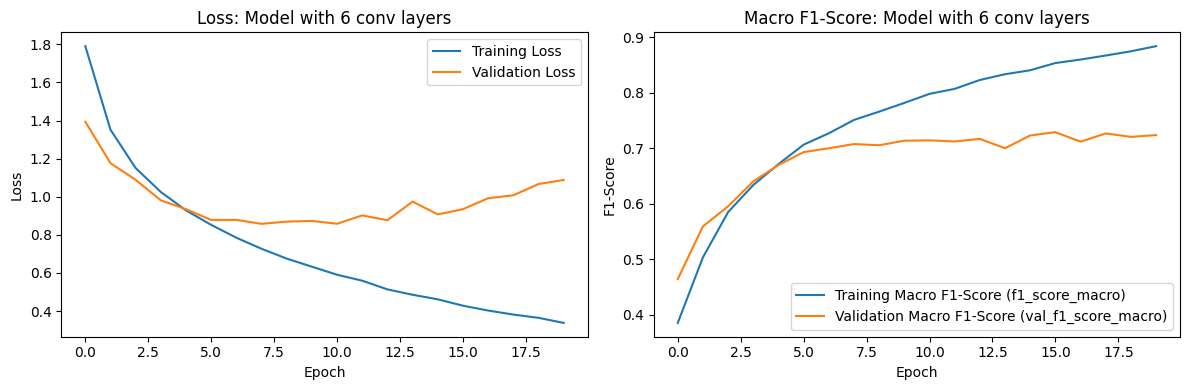

In [12]:
print("\n--- Loss Graphs (Number of Convolutional Layers) ---")
for name, history_data_dict in histories_conv_layers.items():
    mock_history_object = MockHistory(history_data_dict)
    plot_history(mock_history_object, f'Model with {name.replace("_", " ")}')

In [13]:
def create_model_varied_filters(filter_config, input_shape, num_classes, base_model_name="CNN"):
    model = models.Sequential(name=f"{base_model_name}_Filters_{'_'.join(map(str, filter_config))}")
    model.add(layers.Input(shape=input_shape))

    kernel_size = (3, 3)
    pool_size = (2, 2)

    for i, num_filters in enumerate(filter_config):
        model.add(layers.Conv2D(num_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

filter_variations = {
    "few_filters": [16, 32, 64],   
    "medium_filters": [32, 64, 128],
    "many_filters": [64, 128, 256]  
}

histories_num_filters = {}
f1_scores_num_filters = {}

print("\n--- Starting Experiment: Number of Filters per Layer ---")
for name, config in filter_variations.items():
    model_name = f"{name}_config"
    print(f"\nTraining model with filter configuration: {name} ({config})...")
    model = create_model_varied_filters(config, INPUT_SHAPE, NUM_CLASSES, base_model_name="3ConvLayer")
    model.summary()
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_num_filters[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_num_filters[model_name] = f1

experiment_results['num_filters'] = {
    'f1_scores': f1_scores_num_filters,
    'histories': histories_num_filters
}


--- Starting Experiment: Number of Filters per Layer ---

Training model with filter configuration: few_filters ([16, 32, 64])...


Model: "3ConvLayer_Filters_16_32_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,074 (609.66 KB)

 Trainable params: 156,074 (609.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - accuracy: 0.3000 - f1_score_macro: 0.2855 - loss: 1.8814 - val_accuracy: 0.5047 - val_f1_score_macro: 0.4812 - val_loss: 1.3389
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5017 - f1_score_macro: 0.4944 - loss: 1.3832 - val_accuracy: 0.5738 - val_f1_score_macro: 0.5678 - val_loss: 1.1717
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5668 - f1_score_macro: 0.5621 - loss: 1.2182 - val_accuracy: 0.6228 - val_f1_score_macro: 0.6285 - val_loss: 1.0634
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6050 - f1_score_macro: 0.6023 - loss: 1.1158 - val_accuracy: 0.6546 - val_f1_score_macro: 0.6590 - val_loss: 0.9993
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6359 - f1_score_macro: 0.6333 - loss: 1.0413 - val_accuracy: 0.6747 - val_f1_score_macro: 0.6767 - val_loss: 0.9344
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6604 - f1_sc

Model: "3ConvLayer_Filters_32_64_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.3063 - f1_score_macro: 0.4723 - loss: 1.8619 - val_accuracy: 0.5522 - val_f1_score_macro: 0.5537 - val_loss: 1.2386
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5359 - f1_score_macro: 0.5290 - loss: 1.2972 - val_accuracy: 0.6415 - val_f1_score_macro: 0.6392 - val_loss: 1.0272
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6109 - f1_score_macro: 0.6083 - loss: 1.1035 - val_accuracy: 0.6748 - val_f1_score_macro: 0.6706 - val_loss: 0.9257
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6599 - f1_score_macro: 0.6562 - loss: 0.9730 - val_accuracy: 0.6960 - val_f1_score_macro: 0.6918 - val_loss: 0.8677
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6918 - f1_score_macro: 0.6896 - loss: 0.8828 - val_accuracy: 0.7143 - val_f1_score_macro: 0.7142 - val_loss: 0.8355
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7167 - f1_sc

Model: "3ConvLayer_Filters_64_128_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,522 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 64ms/step - accuracy: 0.2893 - f1_score_macro: 0.4671 - loss: 1.8979 - val_accuracy: 0.5206 - val_f1_score_macro: 0.5169 - val_loss: 1.3548
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.5238 - f1_score_macro: 0.5167 - loss: 1.3240 - val_accuracy: 0.6438 - val_f1_score_macro: 0.6461 - val_loss: 1.0209
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6072 - f1_score_macro: 0.6030 - loss: 1.1132 - val_accuracy: 0.6591 - val_f1_score_macro: 0.6589 - val_loss: 0.9561
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6601 - f1_score_macro: 0.6585 - loss: 0.9695 - val_accuracy: 0.7167 - val_f1_score_macro: 0.7114 - val_loss: 0.8216
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7041 - f1_score_macro: 0.7031 - loss: 0.8512 - val_accuracy: 0.7015 - val_f1_score_macro: 0.7053 - val_loss: 0.8566
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7270 - f1_sc

In [15]:
print("\n--- F1-Scores (Number of Filters) ---")
for name, score in f1_scores_num_filters.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Number of Filters) ---
few_filters_config: 0.7336
medium_filters_config: 0.7565
many_filters_config: 0.7653



--- Loss Graphs (Number of Filters) ---


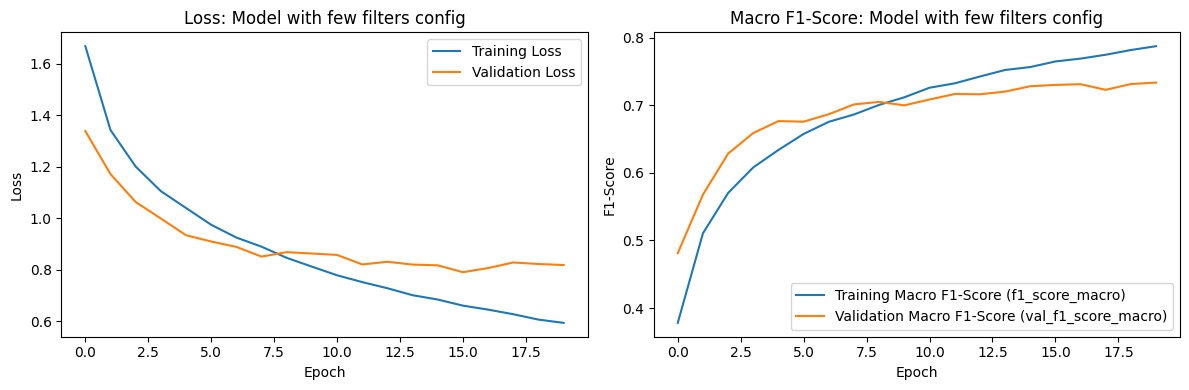

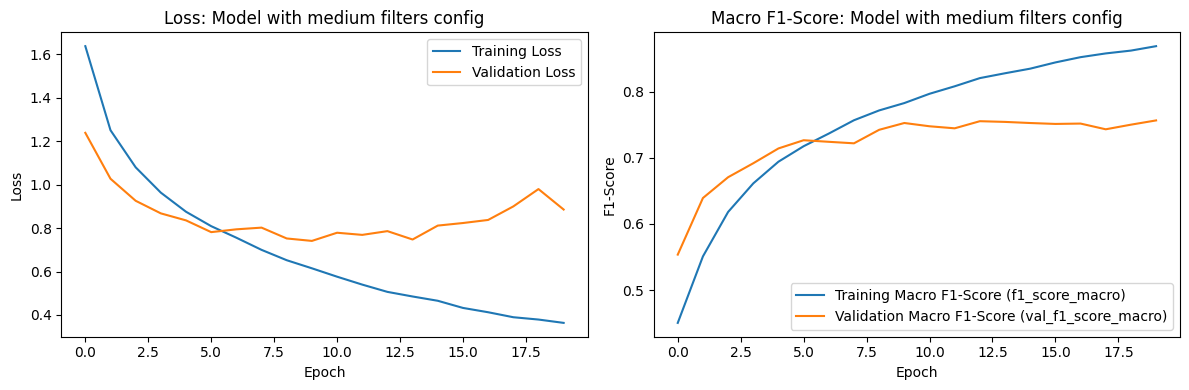

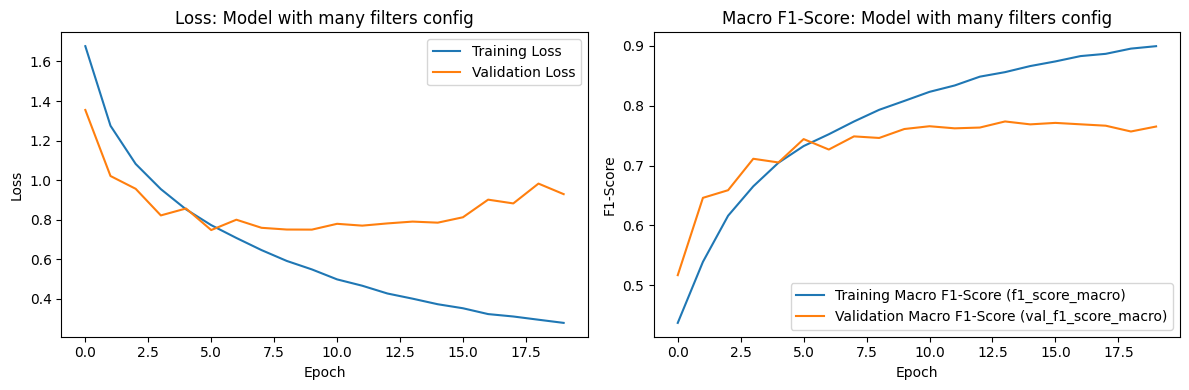

In [16]:
print("\n--- Loss Graphs (Number of Filters) ---")
for name, history_data_dict in histories_num_filters.items():
    mock_history_object = MockHistory(history_data_dict)
    plot_history(mock_history_object, f'Model with {name.replace("_", " ")}')

In [17]:
def create_model_varied_kernel_size(kernel_config, num_filters_per_layer, input_shape, num_classes, base_model_name="CNN"):
    model = models.Sequential(name=f"{base_model_name}_Kernel_{str(kernel_config).replace(', ','-').replace('(','').replace(')','')}")
    model.add(layers.Input(shape=input_shape))
    
    pool_size = (2, 2)
    
    is_list_of_kernels = isinstance(kernel_config, list)

    for i, num_filters in enumerate(num_filters_per_layer):
        kernel_size_to_use = kernel_config[i] if is_list_of_kernels else kernel_config
        model.add(layers.Conv2D(num_filters, kernel_size_to_use, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

default_filters_for_kernel_exp = [32, 64, 128] 

kernel_size_variations = {
    "kernel_3x3": (3,3),
    "kernel_5x5": (5,5),
    "kernel_7x7": (7,7) 
}

histories_kernel_size = {}
f1_scores_kernel_size = {}

print("\n--- Starting Experiment: Filter Size (Kernel Size) ---")
for name, kernel_conf in kernel_size_variations.items():
    model_name = f"{name}_config"
    print(f"\nTraining model with kernel configuration: {name} ({kernel_conf})...")
    model = create_model_varied_kernel_size(kernel_conf, default_filters_for_kernel_exp, INPUT_SHAPE, NUM_CLASSES, base_model_name="3ConvLayer")
    model.summary()

    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_kernel_size[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_kernel_size[model_name] = f1

experiment_results['kernel_size'] = {
    'f1_scores': f1_scores_kernel_size,
    'histories': histories_kernel_size
}


--- Starting Experiment: Filter Size (Kernel Size) ---

Training model with kernel configuration: kernel_3x3 ((3, 3))...


Model: "3ConvLayer_Kernel_3-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.3134 - f1_score_macro: 0.4872 - loss: 1.8644 - val_accuracy: 0.5477 - val_f1_score_macro: 0.5333 - val_loss: 1.2671
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5293 - f1_score_macro: 0.5250 - loss: 1.3141 - val_accuracy: 0.6428 - val_f1_score_macro: 0.6403 - val_loss: 1.0097
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6123 - f1_score_macro: 0.6098 - loss: 1.1005 - val_accuracy: 0.6811 - val_f1_score_macro: 0.6801 - val_loss: 0.9218
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6604 - f1_score_macro: 0.6586 - loss: 0.9708 - val_accuracy: 0.6953 - val_f1_score_macro: 0.6996 - val_loss: 0.8812
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7014 - f1_score_macro: 0.6997 - loss: 0.8612 - val_accuracy: 0.7241 - val_f1_score_macro: 0.7201 - val_loss: 0.7959
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7288 - f1_sc

Model: "3ConvLayer_Kernel_5-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,186 (1.99 MB)

 Trainable params: 522,186 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - accuracy: 0.2875 - f1_score_macro: 0.4682 - loss: 1.9145 - val_accuracy: 0.5487 - val_f1_score_macro: 0.5487 - val_loss: 1.2915
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5311 - f1_score_macro: 0.5248 - loss: 1.3069 - val_accuracy: 0.6152 - val_f1_score_macro: 0.6099 - val_loss: 1.0973
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6175 - f1_score_macro: 0.6139 - loss: 1.0918 - val_accuracy: 0.6779 - val_f1_score_macro: 0.6769 - val_loss: 0.9438
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6705 - f1_score_macro: 0.6680 - loss: 0.9426 - val_accuracy: 0.6855 - val_f1_score_macro: 0.6863 - val_loss: 0.8987
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7060 - f1_score_macro: 0.7050 - loss: 0.8449 - val_accuracy: 0.7026 - val_f1_score_macro: 0.7030 - val_loss: 0.8676
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7380 - f1_sc

Model: "3ConvLayer_Kernel_7-7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,250 (2.94 MB)

 Trainable params: 770,250 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.2760 - f1_score_macro: 0.4457 - loss: 1.9431 - val_accuracy: 0.4929 - val_f1_score_macro: 0.4929 - val_loss: 1.4039
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4923 - f1_score_macro: 0.4878 - loss: 1.4177 - val_accuracy: 0.5669 - val_f1_score_macro: 0.5606 - val_loss: 1.2221
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5792 - f1_score_macro: 0.5765 - loss: 1.2070 - val_accuracy: 0.6205 - val_f1_score_macro: 0.6124 - val_loss: 1.0777
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6386 - f1_score_macro: 0.6357 - loss: 1.0435 - val_accuracy: 0.6360 - val_f1_score_macro: 0.6358 - val_loss: 1.0682
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6724 - f1_score_macro: 0.6717 - loss: 0.9393 - val_accuracy: 0.6694 - val_f1_score_macro: 0.6694 - val_loss: 0.9552
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7036 - f1_sc

In [18]:
print("\n--- F1-Scores (Filter Size) ---")
for name, score in f1_scores_kernel_size.items():
    print(f"{name}: {score:.4f}")


--- F1-Scores (Filter Size) ---
kernel_3x3_config: 0.7610
kernel_5x5_config: 0.7240
kernel_7x7_config: 0.6716



--- Loss Graphs (Filter Size) ---


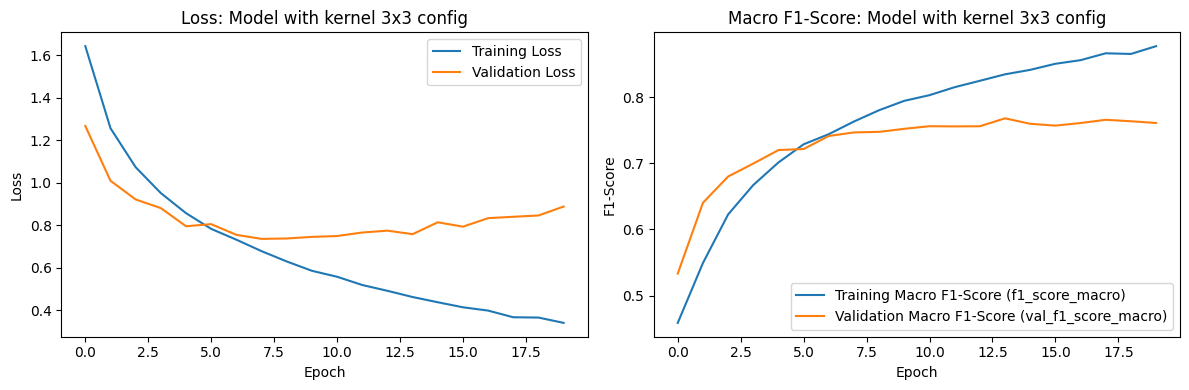

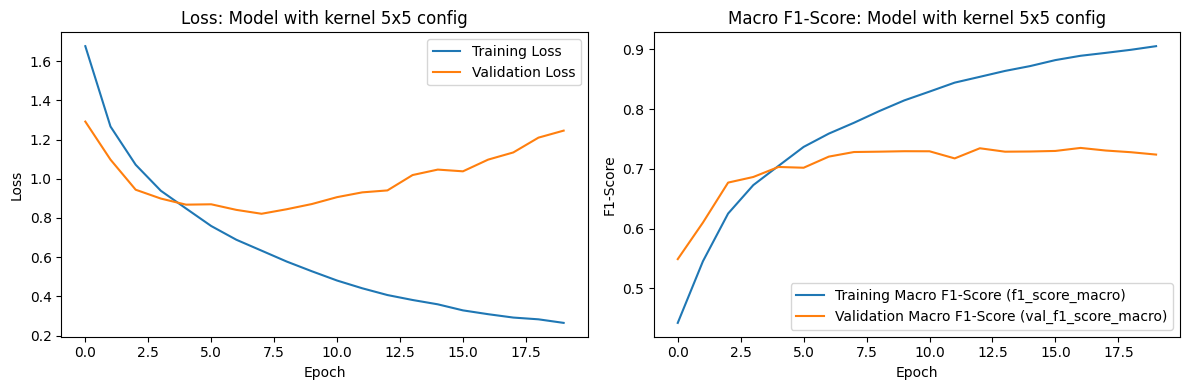

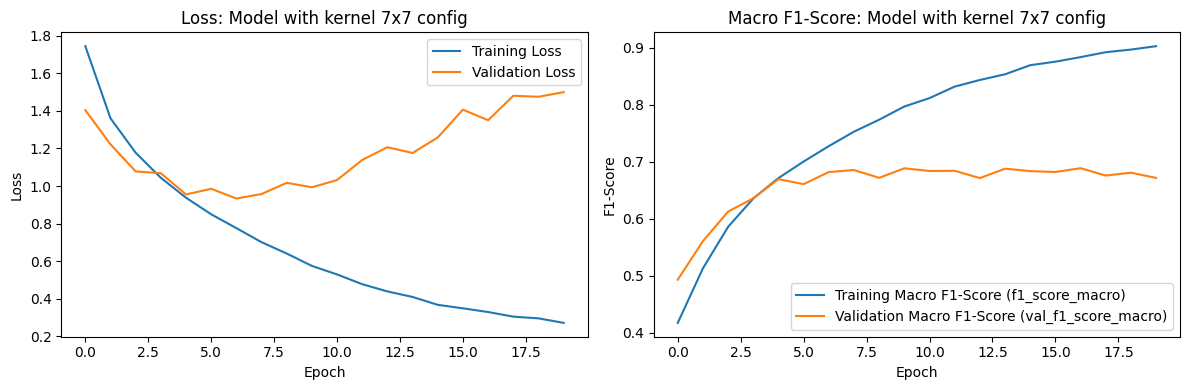

In [19]:
print("\n--- Loss Graphs (Filter Size) ---")
for name, history_data_dict in histories_kernel_size.items():
    mock_history_object = MockHistory(history_data_dict)
    plot_history(mock_history_object, f'Model with {name.replace("_", " ")}')

In [20]:
def create_model_varied_pooling(pooling_type, input_shape, num_classes, base_model_name="CNN_Pooling"):
    model = models.Sequential(name=f"{base_model_name}_{pooling_type.capitalize()}Pool")
    model.add(layers.Input(shape=input_shape))

    filters_config = [32, 64, 128]
    kernel_size = (3,3)
    pool_size = (2,2)

    for i, num_filters in enumerate(filters_config):
        model.add(layers.Conv2D(num_filters, kernel_size, activation='relu', padding='same', name=f"conv2d_layer_{i+1}"))
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size, name=f"maxpool_layer_{i+1}"))
        elif pooling_type == 'average':
            model.add(layers.AveragePooling2D(pool_size, name=f"avgpool_layer_{i+1}"))
        else:
            raise ValueError("Unknown pooling type. Choose 'max' or 'average'.")

    model.add(layers.Flatten(name="flatten_layer"))
    model.add(layers.Dense(128, activation='relu', name="dense_layer_1"))
    model.add(layers.Dropout(0.5, name="dropout_layer"))
    model.add(layers.Dense(num_classes, activation='softmax', name="output_layer"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=METRICS_TO_COMPILE)
    return model

pooling_variations = ["max", "average"]
histories_pooling_type = {}
f1_scores_pooling_type = {}

print("\n--- Starting Experiment: Type of Pooling Layer ---")
for pool_name in pooling_variations:
    model_name = f"{pool_name}_pooling"
    print(f"\nTraining model with {pool_name} pooling...")
    model = create_model_varied_pooling(pool_name, INPUT_SHAPE, NUM_CLASSES)
    model.summary()
    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories_pooling_type[model_name] = history.history
    f1 = evaluate_model_f1(model, X_test, y_test, model_name=model_name)
    f1_scores_pooling_type[model_name] = f1

experiment_results['pooling_type'] = {
    'f1_scores': f1_scores_pooling_type,
    'histories': histories_pooling_type
}


--- Starting Experiment: Type of Pooling Layer ---

Training model with max pooling...


Model: "CNN_Pooling_MaxPool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.3080 - f1_score_macro: 0.4480 - loss: 1.8700 - val_accuracy: 0.5136 - val_f1_score_macro: 0.5095 - val_loss: 1.3739
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5257 - f1_score_macro: 0.5202 - loss: 1.3323 - val_accuracy: 0.6299 - val_f1_score_macro: 0.6250 - val_loss: 1.0538
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6007 - f1_score_macro: 0.5982 - loss: 1.1286 - val_accuracy: 0.6682 - val_f1_score_macro: 0.6684 - val_loss: 0.9469
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6494 - f1_score_macro: 0.6460 - loss: 0.9992 - val_accuracy: 0.6923 - val_f1_score_macro: 0.6890 - val_loss: 0.8796
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6825 - f1_score_macro: 0.6809 - loss: 0.9045 - val_accuracy: 0.7137 - val_f1_score_macro: 0.7133 - val_loss: 0.8126
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7123 - f1_score_m

Model: "CNN_Pooling_AveragePool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer_1 (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_1                 │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_2 (Conv2D)         │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_2                 │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_3 (Conv2D)         │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool_layer_3                 │ (None, 4, 4, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2793 - f1_score_macro: 0.4610 - loss: 1.9364 - val_accuracy: 0.4987 - val_f1_score_macro: 0.4941 - val_loss: 1.3699
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4806 - f1_score_macro: 0.4761 - loss: 1.4379 - val_accuracy: 0.5778 - val_f1_score_macro: 0.5712 - val_loss: 1.1685
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5490 - f1_score_macro: 0.5449 - loss: 1.2628 - val_accuracy: 0.6160 - val_f1_score_macro: 0.6140 - val_loss: 1.0725
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5867 - f1_score_macro: 0.5838 - loss: 1.1604 - val_accuracy: 0.6314 - val_f1_score_macro: 0.6281 - val_loss: 1.0216
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6223 - f1_score_macro: 0.6194 - loss: 1.0713 - val_accuracy: 0.6531 - val_f1_score_macro: 0.6560 - val_loss: 0.9880
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6473 - f1_score_macro:

In [21]:
print("\n--- F1-Scores (Pooling Type) ---")
for name, score in f1_scores_pooling_type.items():
    print(f"{name.replace('_', ' ').capitalize()}: {score:.4f}")


--- F1-Scores (Pooling Type) ---
Max pooling: 0.7599
Average pooling: 0.7656



--- Loss Graphs (Pooling Type) ---


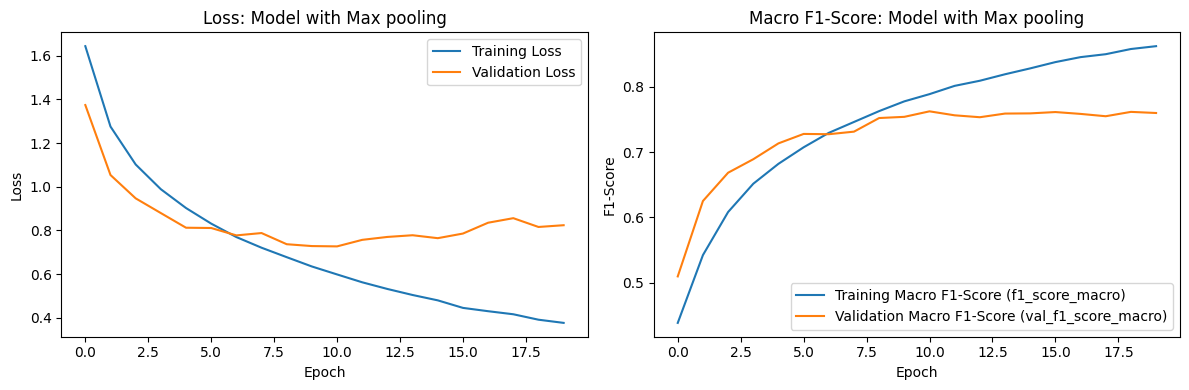

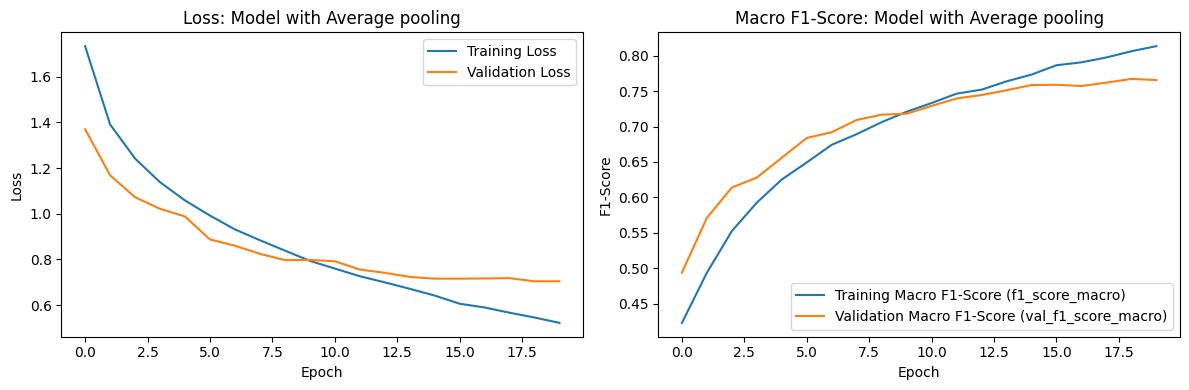

In [22]:
print("\n--- Loss Graphs (Pooling Type) ---")
for name, history_data_dict in histories_pooling_type.items():
    mock_history_object = MockHistory(history_data_dict)
    plot_history(mock_history_object, f'Model with {name.replace("_", " ").capitalize()}')